# **ACKNOWLEDGEMENT**

This code is inspired by https://github.com/songyouwei/ABSA-PyTorch.

# **SETUP**

### **Imports**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import math
import argparse
import sys
import random
import pickle
import spacy
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from time import strftime, localtime
from sklearn import metrics
from xml.etree.ElementTree import parse
from spacy.tokens import Doc

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

# **CLASSES**

### **Data**

In [ ]:
def pad_and_truncate(sequence, max_len, dtype='int64', padding='post', truncating='post', value=0):
    x = (np.ones(max_len) * value).astype(dtype)
    if truncating == 'pre':
        trunc = sequence[-max_len:]
    else:
        trunc = sequence[:max_len]
    trunc = np.asarray(trunc, dtype=dtype)
    if padding == 'post':
        x[:len(trunc)] = trunc
    else:
        x[-len(trunc):] = trunc
    return x

In [ ]:
class Tokenizer():
    def __init__(self, max_len, lower=True):
        self.lower = lower
        self.max_len = max_len
        self.word_to_index = {}
        self.index_to_word = {}
        self.idx = 1

    def fit_on_text(self, text):
        if self.lower:
            text = text.lower()
        words = text.split()
        for word in words:
            if word not in self.word_to_index:
                self.word_to_index[word] = self.idx
                self.index_to_word[self.idx] = word
                self.idx += 1

    def text_to_sequence(self, text, reverse=False, padding='post', truncating='post'):
        if self.lower:
            text = text.lower()
        words = text.split()
        unk = len(self.word_to_index)+1
        sequence = [self.word_to_index[w] if w in self.word_to_index else unk for w in words]
        if len(sequence) == 0:
            sequence = [0]
        if reverse:
            sequence = sequence[::-1]
        return pad_and_truncate(sequence, self.max_len, padding=padding, truncating=truncating)

In [ ]:
class ABSADataset(Dataset):
    def __init__(self, file_name, tokenizer):
        with open(file_name, 'r', newline='\n', encoding='utf-8', errors='ignore') as f:
            lines = f.readlines()
        with open(file_name + '.graph', 'rb') as f:
            index_to_graph = pickle.load(f)
        
        self.data = []

        # Create tokens with tokenizer
        for i in range(0, len(lines), 3):
            left, right = [s.lower().strip() for s in lines[i].split("$T$")]
            aspect = lines[i+1].lower().strip()
            polarity = lines[i+2].strip()

            text_token = tokenizer.text_to_sequence(" ".join([left, aspect, right]))
            context_token = tokenizer.text_to_sequence(" ".join([left, right]))

            left_token = tokenizer.text_to_sequence(left)
            left_aspect_token = tokenizer.text_to_sequence(" ".join([left, aspect]))

            right_token = tokenizer.text_to_sequence(right, reverse=True)
            right_aspect_token = tokenizer.text_to_sequence(" ".join([aspect, right]), reverse=True)

            aspect_token = tokenizer.text_to_sequence(aspect)

            left_len = np.sum(left_token != 0)
            aspect_len = np.sum(aspect_token != 0)
            aspect_boundary = np.asarray([left_len, left_len + aspect_len - 1], dtype = np.int64)
            polarity = int(polarity) + 1
            
            text_len = np.sum(text_token != 0)
            concat_segments_tokens = pad_and_truncate([0] * (text_len + 1) + [1] * (aspect_len + 1), tokenizer.max_len)
            
            dependency_graph = np.pad(index_to_graph[i],
                                      ((0, tokenizer.max_len-index_to_graph[i].shape[0]),
                                       (0, tokenizer.max_len-index_to_graph[i].shape[0])),
                                      'constant')
            
            self.data.append({
                'text_token' : text_token,
                'context_token' : context_token, 
                'left_token' : left_token, 
                'left_aspect_token' : left_aspect_token,
                'right_token' : right_token,
                'right_aspect_token' : right_aspect_token,
                'aspect_token' : aspect_token, 
                'aspect_boundary' : aspect_boundary, 
                'polarity' : polarity, 
                'dependency_graph' : dependency_graph
            })
    
    def __getitem__(self, index):
        return self.data[index]
    
    def __len__(self):
        return len(self.data)

In [ ]:
class WhitespaceTokenizer(object):
    def __init__(self, vocab):
        self.vocab = vocab

    def __call__(self, text):
        words = text.split()
        # All tokens 'own' a subsequent space character in this tokenizer
        spaces = [True] * len(words)
        return Doc(self.vocab, words=words, spaces=spaces)

### **Model**

In [ ]:
class LSTM(nn.Module):
    def __init__(self, embedding_matrix):
        super(LSTM, self).__init__()
        self.embed = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float))
        self.squeeze_embedding = SqueezeEmbedding()
        self.lstm = nn.LSTM(config2["embed_dim"]*2, config2["hidden_dim"], num_layers=1, batch_first=True)
        self.dense = nn.Linear(config2["hidden_dim"], config2["polarities_dim"])
    
    def forward(self, inputs):
        text_indices, aspect_indices = inputs[0], inputs[1]
        x_len = torch.sum(text_indices != 0, dim=-1)
        x_len_max = torch.max(x_len)
        aspect_len = torch.sum(aspect_indices != 0, dim=-1).float()

        x = self.embed(text_indices)
        x = self.squeeze_embedding(x, x_len)
        aspect = self.embed(aspect_indices)
        aspect_pool = torch.div(torch.sum(aspect, dim=1), aspect_len.unsqueeze(1))
        aspect = aspect_pool.unsqueeze(1).expand(-1, x_len_max, -1)
        x = torch.cat((aspect, x), dim=-1)

        x_emb_p = torch.nn.utils.rnn.pack_padded_sequence(x, x_len, batch_first=True, enforce_sorted=False)

        # global ht
        out_pack, (ht, ct) = self.lstm(x_emb_p, None)

        return self.dense(ht[0])

In [ ]:
class SqueezeEmbedding(nn.Module):
    """
    Squeeze sequence embedding length to the longest one in the batch
    """
    def __init__(self, batch_first=True):
        super(SqueezeEmbedding, self).__init__()
        self.batch_first = batch_first

    def forward(self, x, x_len):
        """
        sequence -> sort -> pad and pack -> unpack ->unsort
        :param x: sequence embedding vectors
        :param x_len: numpy/tensor list
        :return:
        """
        """sort"""
        x_sort_idx = torch.sort(-x_len)[1].long()
        x_unsort_idx = torch.sort(x_sort_idx)[1].long()
        x_len = x_len[x_sort_idx]
        x = x[x_sort_idx]
        """pack"""
        x_emb_p = torch.nn.utils.rnn.pack_padded_sequence(x, x_len.cpu(), batch_first=self.batch_first)
        """unpack: out"""
        out = torch.nn.utils.rnn.pad_packed_sequence(x_emb_p, batch_first=self.batch_first)  # (sequence, lengths)
        out = out[0]  #
        """unsort"""
        out = out[x_unsort_idx]
        return out

### **Main**

In [ ]:
class Instructor:
    def __init__(self):
        tokenizer = build_tokenizer(
            fnames=[config2["dataset_file"]['train'], config2["dataset_file"]['test']],
            max_seq_len=config2["max_seq_len"],
            dat_fname='{0}_tokenizer.dat'.format(config2["dataset"]))
        embedding_matrix = build_embedding_matrix(
            word2idx=tokenizer.word_to_index,
            embed_dim=config2["embed_dim"],
            dat_fname='{0}_{1}_embedding_matrix.dat'.format(str(config2["embed_dim"]), config2["dataset"]))
        self.model = config2["model_class"](embedding_matrix).to(config2["device"])

        self.trainset = ABSADataset(config2["dataset_file"]['train'], tokenizer)
        self.testset = ABSADataset(config2["dataset_file"]['test'], tokenizer)
        self.valset = ABSADataset(config2["dataset_file"]['val'], tokenizer)

        if config2["device"].type == 'cuda':
            print('cuda memory allocated: {}'.format(torch.cuda.memory_allocated(device=config2["device"].index)))
        self._print_args()

    def _print_args(self):
        n_trainable_params, n_nontrainable_params = 0, 0
        for p in self.model.parameters():
            n_params = torch.prod(torch.tensor(p.shape))
            if p.requires_grad:
                n_trainable_params += n_params
            else:
                n_nontrainable_params += n_params
        print('> n_trainable_params: {0}, n_nontrainable_params: {1}'.format(n_trainable_params, n_nontrainable_params))


    def _reset_params(self):
        for child in self.model.children():
            for p in child.parameters():
                if p.requires_grad:
                    if len(p.shape) > 1:
                        config2["initializer"](p)
                    else:
                        stdv = 1. / math.sqrt(p.shape[0])
                        torch.nn.init.uniform_(p, a=-stdv, b=stdv)

    def _train(self, criterion, optimizer, train_data_loader, val_data_loader):
        max_val_acc = 0
        max_val_f1 = 0
        max_val_epoch = 0
        global_step = 0
        path = None
        train_losses = []
        train_accuracies = []
        val_losses = []
        val_accuracies = []
        for i_epoch in range(config2["num_epoch"]):
            print('>' * 100)
            print('epoch: {}'.format(i_epoch))
            n_correct, n_total, loss_total = 0, 0, 0
            # switch model to training mode
            self.model.train()
            for i_batch, batch in enumerate(train_data_loader):
                global_step += 1
                # clear gradient accumulators
                optimizer.zero_grad()

                inputs = [batch[col].to(config2["device"]) for col in config2["inputs_cols"]]
                global outputs, targets
                outputs = self.model(inputs)
                targets = batch['polarity'].to(config2["device"])
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

                n_correct += (torch.argmax(outputs, -1) == targets).sum().item()
                n_total += len(outputs)
                loss_total += loss.item() * len(outputs)
                if global_step % config2["log_step"] == 0:
                    train_acc = n_correct / n_total
                    train_loss = loss_total / n_total
                    print('[epoch {}] loss: {:.4f}, acc: {:.4f}'.format(i_epoch, train_loss, train_acc))

            val_acc, val_loss, _, val_f1, _, _, _, _, _, _, _, _ = self._evaluate(criterion, val_data_loader)
            print('> val_acc: {:.4f}, val_f1: {:.4f}'.format(val_acc, val_f1))
            if val_acc > max_val_acc:
                max_val_acc = val_acc
                max_val_epoch = i_epoch
                if not os.path.exists('state_dict'):
                    os.mkdir('state_dict')
                path = '{0}/{1}_{2}_val_acc_{3}'.format(config["model_path"], config2["model_name"], config2["dataset"], round(val_acc, 4))
                torch.save(self.model.state_dict(), path)
                print('>> saved: {}'.format(path))
            if val_f1 > max_val_f1:
                max_val_f1 = val_f1
            if i_epoch - max_val_epoch >= config2["patience"]:
                print('>> early stop.')
                break
            train_losses.append(loss_total / n_total)
            train_accuracies.append(n_correct / n_total)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)

        return path, train_losses, train_accuracies, val_losses, val_accuracies

    def _evaluate(self, criterion, data_loader):
        n_correct, n_total, loss_total = 0, 0, 0
        t_targets_all, t_outputs_all = None, None
        # switch model to evaluation mode
        self.model.eval()
        with torch.no_grad():
            for i_batch, t_batch in enumerate(data_loader):
                t_inputs = [t_batch[col].to(config2["device"]) for col in config2["inputs_cols"]]
                t_targets = t_batch['polarity'].to(config2["device"])
                t_outputs = self.model(t_inputs)

                loss = criterion(t_outputs, t_targets)

                n_correct += (torch.argmax(t_outputs, -1) == t_targets).sum().item()
                n_total += len(t_outputs)
                loss_total += loss.item() * len(t_outputs)

                if t_targets_all is None:
                    t_targets_all = t_targets
                    t_outputs_all = t_outputs
                else:
                    t_targets_all = torch.cat((t_targets_all, t_targets), dim=0)
                    t_outputs_all = torch.cat((t_outputs_all, t_outputs), dim=0)

        acc = n_correct / n_total
        loss = loss_total / n_total
        f1_macro = metrics.f1_score(t_targets_all.cpu(), torch.argmax(t_outputs_all, -1).cpu(), labels=[0, 1, 2], average='macro')
        f1_micro = metrics.f1_score(t_targets_all.cpu(), torch.argmax(t_outputs_all, -1).cpu(), labels=[0, 1, 2], average='micro')
        f1_weighted = metrics.f1_score(t_targets_all.cpu(), torch.argmax(t_outputs_all, -1).cpu(), labels=[0, 1, 2], average='weighted')
        precision_macro = metrics.precision_score(t_targets_all.cpu(), torch.argmax(t_outputs_all, -1).cpu(), labels=[0, 1, 2], average = 'macro')
        precision_micro = metrics.precision_score(t_targets_all.cpu(), torch.argmax(t_outputs_all, -1).cpu(), labels=[0, 1, 2], average = 'micro')
        precision_weighted = metrics.precision_score(t_targets_all.cpu(), torch.argmax(t_outputs_all, -1).cpu(), labels=[0, 1, 2], average = 'weighted')
        recall_macro = metrics.recall_score(t_targets_all.cpu(), torch.argmax(t_outputs_all, -1).cpu(), labels=[0, 1, 2], average = 'macro')
        recall_micro = metrics.recall_score(t_targets_all.cpu(), torch.argmax(t_outputs_all, -1).cpu(), labels=[0, 1, 2], average = 'micro')
        recall_weighted = metrics.recall_score(t_targets_all.cpu(), torch.argmax(t_outputs_all, -1).cpu(), labels=[0, 1, 2], average = 'weighted')
        confusion_matrix = metrics.confusion_matrix(t_targets_all.cpu(), torch.argmax(t_outputs_all, -1).cpu(), labels=[0, 1, 2])
        return acc, loss, f1_macro, f1_micro, f1_weighted, precision_macro, precision_micro, precision_weighted, recall_macro, recall_micro, recall_weighted, confusion_matrix

    def run(self):
        # Loss and Optimizer
        criterion = nn.CrossEntropyLoss()
        _params = filter(lambda p: p.requires_grad, self.model.parameters())
        optimizer = config2["optimizer"](_params, lr=config2["lr"], weight_decay=config2["l2reg"])

        train_data_loader = DataLoader(dataset=self.trainset, batch_size=config2["batch_size"], shuffle=True)
        test_data_loader = DataLoader(dataset=self.testset, batch_size=config2["batch_size"], shuffle=False)
        val_data_loader = DataLoader(dataset=self.valset, batch_size=config2["batch_size"], shuffle=False)

        self._reset_params()
        best_model_path, train_losses, train_accuracies, val_losses, val_accuracies = self._train(criterion, optimizer, train_data_loader, val_data_loader)
        self.model.load_state_dict(torch.load(best_model_path))
        acc, test_losses, f1_macro, f1_micro, f1_weighted, precision_macro, precision_micro, precision_weighted, recall_macro, recall_micro, recall_weighted, confusion_matrix = self._evaluate(nn.CrossEntropyLoss(), test_data_loader)
        print('>> test_acc: {:.4f}'.format(acc))
        print('>> test_f1_macro: {:.4f}'.format(f1_macro))
        print('>> test_f1_micro: {:.4f}'.format(f1_micro))
        print('>> test_f1_weighted: {:.4f}'.format(f1_weighted))
        print('>> test_precision_macro: {:.4f}'.format(precision_macro))
        print('>> test_precision_micro: {:.4f}'.format(precision_micro))
        print('>> test_precision_weighted: {:.4f}'.format(precision_weighted))
        print('>> test_recall_macro: {:.4f}'.format(recall_macro))
        print('>> test_recall_micro: {:.4f}'.format(recall_micro))
        print('>> test_recall_weighted: {:.4f}'.format(recall_weighted))
        print('confusion matrix:')
        print(confusion_matrix)

        epochs = len(train_losses)
        plt.figure(figsize=(12, 4))
        for i, metrics in enumerate(zip([train_losses, train_accuracies], [val_losses, val_accuracies], ['Loss', 'Accuracy'])):
            plt.subplot(1, 2, i + 1)
            plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
            plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
            plt.legend()
        plt.show()
        plt.savefig('lstm_accuracy.png')
        return best_model_path, train_losses, train_accuracies, val_losses, val_accuracies, acc, test_losses, f1_macro, f1_micro, f1_weighted, precision_macro, precision_micro, precision_weighted, recall_macro, recall_micro, recall_weighted, confusion_matrix

# **Functions**

In [ ]:
def change_format_sentences(source_path, target_path):
    f = open(target_path, "w")

    sentences = parse(source_path).getroot()
    preprocessed = []

    for sentence in sentences:
        text = sentence.find('text')
        if text is None:
            continue
        text = text.text
        aspectTerms = sentence.find('aspectTerms')
        if aspectTerms is None:
            continue
        for aspectTerm in aspectTerms:
            term = aspectTerm.get('term')
            polarity = aspectTerm.get('polarity')
            if polarity == "positive":
                polarity = '1'
            elif polarity == "neutral":
                polarity = '0'
            elif polarity == "negative":
                polarity = '-1'
            else:
                raise Exception("invalid polarity!")
            start = int(aspectTerm.get('from'))
            end = int(aspectTerm.get('to'))
            preprocessed.append(text[:start] + "$T$" + text[end:])
            preprocessed.append(text[start:end])
            preprocessed.append(polarity)
    f.write("\n".join(preprocessed))

In [ ]:
def build_tokenizer(fnames, max_seq_len, dat_fname):
    if os.path.exists(dat_fname):
        print('loading tokenizer:', dat_fname)
        tokenizer = pickle.load(open(dat_fname, 'rb'))
    else:
        text = ''
        for fname in fnames:
            fin = open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
            lines = fin.readlines()
            fin.close()
            for i in range(0, len(lines), 3):
                text_left, _, text_right = [s.lower().strip() for s in lines[i].partition("$T$")]
                aspect = lines[i + 1].lower().strip()
                text_raw = text_left + " " + aspect + " " + text_right
                text += text_raw + " "

        tokenizer = Tokenizer(max_seq_len)
        tokenizer.fit_on_text(text)
        pickle.dump(tokenizer, open(dat_fname, 'wb'))
    return tokenizer

In [ ]:
def _load_word_vec(path, word2idx=None, embed_dim=300):
    fin = open(path, 'r', encoding='utf-8', newline='\n', errors='ignore')
    word_vec = {}
    for line in fin:
        tokens = line.rstrip().split()
        word, vec = ' '.join(tokens[:-embed_dim]), tokens[-embed_dim:]
        if word in word2idx.keys():
            word_vec[word] = np.asarray(vec, dtype='float32')
    return word_vec

In [ ]:
def build_embedding_matrix(word2idx, embed_dim, dat_fname):
    if os.path.exists(dat_fname):
        print('loading embedding_matrix:', dat_fname)
        embedding_matrix = pickle.load(open(dat_fname, 'rb'))
    else:
        print('loading word vectors...')
        embedding_matrix = np.zeros((len(word2idx) + 2, embed_dim))  # idx 0 and len(word2idx)+1 are all-zeros
        fname = config["glove_path"]
        word_vec = _load_word_vec(fname, word2idx=word2idx, embed_dim=embed_dim)
        print('building embedding_matrix:', dat_fname)
        for word, i in word2idx.items():
            vec = word_vec.get(word)
            if vec is not None:
                # words not found in embedding index will be all-zeros.
                embedding_matrix[i] = vec
        pickle.dump(embedding_matrix, open(dat_fname, 'wb'))
    return embedding_matrix

In [ ]:
def pad_and_truncate(sequence, maxlen, dtype='int64', padding='post', truncating='post', value=0):
    x = (np.ones(maxlen) * value).astype(dtype)
    if truncating == 'pre':
        trunc = sequence[-maxlen:]
    else:
        trunc = sequence[:maxlen]
    trunc = np.asarray(trunc, dtype=dtype)
    if padding == 'post':
        x[:len(trunc)] = trunc
    else:
        x[-len(trunc):] = trunc
    return x

In [ ]:
def dependency_adj_matrix(text):
    # https://spacy.io/docs/usage/processing-text
    tokens = nlp(text)
    words = text.split()
    matrix = np.zeros((len(words), len(words))).astype('float32')
    assert len(words) == len(list(tokens))

    for token in tokens:
        matrix[token.i][token.i] = 1
        for child in token.children:
            matrix[token.i][child.i] = 1
            matrix[child.i][token.i] = 1

    return matrix

In [ ]:
def process_data():
    change_format_sentences(config["raw_train_path"], config["processed_train_path"])
    change_format_sentences(config["raw_val_path"], config["processed_val_path"])
    change_format_sentences(config["raw_test_path"], config["processed_test_path"])
    process(config["processed_train_path"])
    process(config["processed_val_path"])
    process(config["processed_test_path"])

In [ ]:
def process(filename):
    fin = open(filename, 'r', encoding='utf-8', newline='\n', errors='ignore')
    lines = fin.readlines()
    fin.close()
    idx2graph = {}
    fout = open(filename+'.graph', 'wb')
    for i in range(0, len(lines), 3):
        text_left, _, text_right = [s.strip() for s in lines[i].partition("$T$")]
        aspect = lines[i + 1].strip()
        adj_matrix = dependency_adj_matrix(text_left+' '+aspect+' '+text_right)
        idx2graph[i] = adj_matrix
    pickle.dump(idx2graph, fout)        
    fout.close() 

In [ ]:
def run():
    ins = Instructor()
    best_model_path, train_losses, train_accuracies, val_losses, val_accuracies, acc, test_losses, f1_macro, f1_micro, f1_weighted, precision_macro, precision_micro, precision_weighted, recall_macro, recall_micro, recall_weighted, confusion_matrix = ins.run()
    return best_model_path, train_losses, train_accuracies, val_losses, val_accuracies, acc, test_losses, f1_macro, f1_micro, f1_weighted, precision_macro, precision_micro, precision_weighted, recall_macro, recall_micro, recall_weighted, confusion_matrix


# **MAIN**

### **Configuration**

In [ ]:
nlp = spacy.load('en_core_web_sm')
nlp.tokenizer = WhitespaceTokenizer(nlp.vocab)

In [ ]:
config = {
    "base_path": "/content/drive/MyDrive/CS4248/MAMS-ATSA",
    "glove_path": "/content/drive/MyDrive/CS4248/glove.42B.300d.txt"
}

config["model_path"] = os.path.join(config["base_path"], 'lstm_models')
config["raw_train_path"] = os.path.join(config["base_path"], 'raw/train.xml')
config["raw_val_path"] = os.path.join(config["base_path"], 'raw/val.xml')
config["raw_test_path"] = os.path.join(config['base_path'], 'raw/test.xml')
config["processed_train_path"] = os.path.join(config["base_path"], 'raw/train_processed.xml.seg')
config["processed_val_path"] = os.path.join(config["base_path"], 'raw/val_processed.xml.seg')
config["processed_test_path"] = os.path.join(config['base_path'], 'raw/test_processed.xml.seg')

In [ ]:
dataset_files = {
    'train': config["processed_train_path"],
    'test': config["processed_test_path"],
    'val': config["processed_val_path"]
}

config2 = {
    "model_name" : "LSTM",
    "lr" : 3e-5,
    "dropout" : 0.1,
    "l2reg" : 0.001,
    "num_epoch" : 20,
    "batch_size" : 25,
    "log_step" : 10,
    "embed_dim" : 300,
    "hidden_dim" : 300,
    "model_class" : LSTM,
    "dataset": "MAMS",
    "dataset_file" : dataset_files,
    "inputs_cols" : ['text_token', 'aspect_token'],
    "initializer" : torch.nn.init.xavier_uniform_,
    "optimizer" : torch.optim.Adam,
    "max_seq_len" : 85,
    "polarities_dim" : 3,
    "patience" : 5, # for early stopping
    "device" : None,
    "seed" : 1234,
    "valset_ratio" : 0
}

config2["device"] = torch.device('cuda' if torch.cuda.is_available() else 'cpu') \
        if config2["device"] is None else torch.device(config2["device"])

if config2["seed"] is not None:
    random.seed(config2["seed"])
    np.random.seed(config2["seed"])
    torch.manual_seed(config2["seed"])
    torch.cuda.manual_seed(config2["seed"])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(config2["seed"])

### **Pipeline**

In [ ]:
# uncomment this line only for the first time you run this file
# process_data()

loading tokenizer: MAMS_tokenizer.dat
loading embedding_matrix: 300_MAMS_embedding_matrix.dat
> n_trainable_params: 1083303, n_nontrainable_params: 3994500
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
epoch: 0
[epoch 0] loss: 1.1110, acc: 0.3920
[epoch 0] loss: 1.0863, acc: 0.4160
[epoch 0] loss: 1.0679, acc: 0.4360
[epoch 0] loss: 1.0548, acc: 0.4380
[epoch 0] loss: 1.0487, acc: 0.4400
[epoch 0] loss: 1.0386, acc: 0.4533
[epoch 0] loss: 1.0303, acc: 0.4651
[epoch 0] loss: 1.0256, acc: 0.4740
[epoch 0] loss: 1.0199, acc: 0.4844
[epoch 0] loss: 1.0141, acc: 0.4896
[epoch 0] loss: 1.0087, acc: 0.4956
[epoch 0] loss: 1.0027, acc: 0.5047
[epoch 0] loss: 1.0001, acc: 0.5071
[epoch 0] loss: 0.9940, acc: 0.5131
[epoch 0] loss: 0.9888, acc: 0.5171
[epoch 0] loss: 0.9858, acc: 0.5202
[epoch 0] loss: 0.9850, acc: 0.5219
[epoch 0] loss: 0.9822, acc: 0.5231
[epoch 0] loss: 0.9778, acc: 0.5274
[epoch 0] loss: 0.9735, acc: 0.5316
[epoch 0] loss

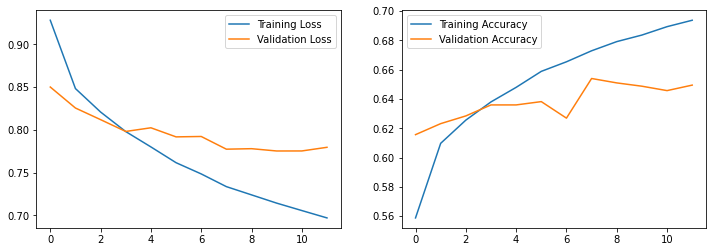

<Figure size 432x288 with 0 Axes>

In [ ]:
best_model_path, train_losses, train_accuracies, val_losses, val_accuracies, acc, test_losses, f1_macro, f1_micro, f1_weighted, precision_macro, precision_micro, precision_weighted, recall_macro, recall_micro, recall_weighted, confusion_matrix = run()